# Object Localization & Semantic Segmentation

In addition to classifying images (this is an image of a dog, this is an image of a cat...) CNN's can be used to determine the location of something in an image. Generally speaking localization entails bounding the object in question with a tight rectangle. There are multiple forms of this, including:

* Single object localization: identify a single object and localize it within a bounding box.
* Multiple object localization (sometimes called Object Detection): Identify and bound all relevant objects within a rectangle (i.e one bounding box per object)
* Semantic segmentation: identify exactly which pixels belong to objects (instead of a bounding box)

![](img/pet_annotations.jpg)

> Image source Oxford Pet dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

For each of these three categories, a network might be designed to detect many different classes of objects or only identify a single kind of object. For example, you could design a network that:

* Only detects the location of a single dog. 
* Detects the location of a dog, or a cat, and classifies it as such.
* Detects the location of all dogs and cats, but doesn't classify them as dog or cat.
* Detects the location of all dogs and cats and labels each instance as dog or cat. 
* ... and so on ...

The same networks that perform well on classification tasks can often be re-purposed to perform localization, but  the output layers need to change significantly. As you might imagine, the complexity of our solutions increase as the complexity of the task increases: Detecting the location of the dog in a dataset that's all images of dogs is much easier than localizing all of the objects beloinging to 1 of 1000 target classes. Similarly, detecting a bounding box is easier than detecting exactly which pixels contain the object in question.

In this section we are going to limit ourselves to **single object localization** on the implementation side. We will discuss changes that allow for multiple object detection/localization as well as segmentation. Additional study materials are provided in the readme regarding multiple object localization.




Often, setting up the data is one of the most tediuous and challenging aspects of an ML project. Lets quickly take a look at the data provided before we start processing it. 

The images are all photos of an individual animal. There are ~200 samples of each type of animal. They are all dogs or cats of varying breeds. The shape of the image and positioning, posture, and angle of the animal varies from picture to picture. 

![](img/Abyssinian_223.jpg)
![](img/american_bulldog_138.jpg)
![](img/basset_hound_61.jpg)


The various sizes present a challenge, since our net expects each image to have the same shape. In the past we handled this by padding the image to square then reshapping them. That same strategy can work here (and we have to do SOMETHING) but the bounding boxes provided map to the original input, so we have to keep that in mind. 

Next, the image-to-class mapping is in a CSV file, here are some sample entries:

```
Abyssinian_113 1 1 1
yorkshire_terrier_95 37 2 25
wheaten_terrier_196 36 2 24
Siamese_49 33 1 11
```

The columns are:

```
image_name class_id species_id breed_id
```

Though the dataset gives us the ability to classify each breed of cat/dog individually, we're going to make things a bit easier just focus on species_id, 1 for cat, 2 for dog. 


Finally, the bounding box annotations are in an XML format called PASCAL VOC. There are specialized readers that can parse this format specifically, but we can also use Pythons built in XML parser without much trouble. 

```xml
<?xml version="1.0" encoding="UTF-8"?>
<annotation>
   <folder>OXIIIT</folder>
   <filename>Abyssinian_1.jpg</filename>
   <source>
      <database>OXFORD-IIIT Pet Dataset</database>
      <annotation>OXIIIT</annotation>
      <image>flickr</image>
   </source>
   <size>
      <width>600</width>
      <height>400</height>
      <depth>3</depth>
   </size>
   <segmented>0</segmented>
   <object>
      <name>cat</name>
      <pose>Frontal</pose>
      <truncated>0</truncated>
      <occluded>0</occluded>
      <bndbox>
         <xmin>333</xmin>
         <ymin>72</ymin>
         <xmax>425</xmax>
         <ymax>158</ymax>
      </bndbox>
      <difficult>0</difficult>
   </object>
</annotation>
```

In [1]:
# All the imports:
from collections import namedtuple

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, image as keras_image
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

# This is new, the XML parsing library comes with Python
import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [50]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = 'pets_dataset/images'
PATH_TO_CLASS_LIST = 'pets_dataset/annotations/list.txt'
PATH_TO_XML_ANNOTATIONS = 'pets_dataset/annotations/xmls'

# Change if you wish. 
TARGET_SIZE = (200, 200)

In [9]:
# Just to make the code a bit easier to read.
BoundingBox = namedtuple('BoundingBox', 'xmin ymin xmax ymax')

# A function to read the XML and return (xmin, ymin, xmax, ymax)
def get_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)

    return BoundingBox(xmin, ymin, xmax, ymax)

In [52]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. Much of this comes from last lab
# and should look familiar.
def resize_image_with_bounds(path_to_image, bounding_box, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    new_xmin = bounding_box.xmin + w_pad
    new_xmax = bounding_box.xmax + w_pad
    new_ymin = bounding_box.ymin + h_pad
    new_ymax = bounding_box.ymax + h_pad
    
    # When we resize the image, it's by some scalar. We have to apply that 
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        print(BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax))
        print(width_scale, height_scale)

        new_xmin = new_xmin * width_scale
        new_xmax = new_xmax * width_scale
        new_ymin = new_ymin * height_scale
        new_ymax = new_ymax * height_scale
    
    # Last thing: we're going to scale all the default (0-255) RGB
    # values to be floats from 0-1. If we do not do this in some cases
    # the generators we use below wrongly interpret the int's as floats
    # and clip values greater than 1. It's a strange bug you wouldn't expect
    # so it's better to just handle it here!
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are in the 0-255 range.
    return image_data, BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax)

In [7]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    
    return (image_data, bounding_box)

In [5]:
# Given the image data, plot the data with the bounding box.
# for testing/verification purposes. 
def plot_with_box(image_data, bounding_box):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch. 
    rect = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

BoundingBox(xmin=111.0, ymin=86.0, xmax=141.66666666666666, ymax=129.0)


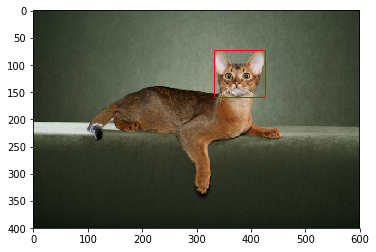

BoundingBox(xmin=333, ymin=172, xmax=425, ymax=258)


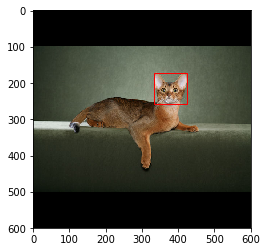

BoundingBox(xmin=333, ymin=172, xmax=425, ymax=258)
0.3333333333333333 0.3333333333333333
BoundingBox(xmin=111.0, ymin=57.33333333333333, xmax=141.66666666666666, ymax=86.0)


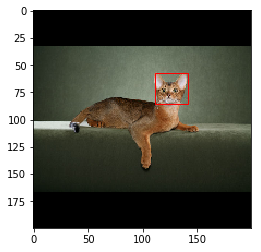

In [53]:
sample_name = 'Abyssinian_1'
species = 1

image, bounding_box = prepare_sample_from_name(sample_name, species)
plot_with_box(image, bounding_box)
